## Thompson Controlled Mixture Sampling for Global Noisy Non-Convex Maximization

In [394]:
# some utility functions

def phi_1(x):
    return x * (1 - x)

def phi_2(x):
    return 2 + 2 * x * (1 - 2 * x) + (1 / 50) * np.sin(52 * np.pi * x)

def gaussian_noise(x, seed=None):
    rng = np.random.default_rng(seed)
    sigma = (1 - x)**2  # Variance decreases with x
    return rng.normal(0, sigma)

def phi_1_noisy(x, seed=None):
    return phi_1(x) + gaussian_noise(x)

def phi_2_noisy(x, seed=None):
    return phi_2(x) + gaussian_noise(x)

import numpy as np

def build_proposal_probabilities(mu, sigma, num_samples=1000):
    """
    Build proposal probabilities from the joint Gaussian distribution.

    Args:
        mu (array): Mean vector [mu_1, mu_2, ..., mu_m].
        sigma (array): Variance vector [var_1, var_2, ..., var_m].
        num_samples (int): Number of samples to draw.

    Returns:
        proposal_probabilities (array): Normalized probabilities for each interval.
    """
    m = len(mu)  # Number of intervals
    covariance = np.diag(sigma)  # Diagonal covariance matrix
    samples = np.random.multivariate_normal(mu, covariance, size=num_samples)
    
    # Count maxima
    max_counts = np.zeros(m)
    for sample in samples:
        max_idx = np.argmax(sample)
        max_counts[max_idx] += 1

    # Normalize to get proposal probabilities
    proposal_probabilities = max_counts / num_samples
    return proposal_probabilities

def get_entropy(P_t):
    return -np.sum(P_t*np.log(P_t))


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as random

### 1. The Problem

#### Non-Convex Functions - Characteristic and Challenges:

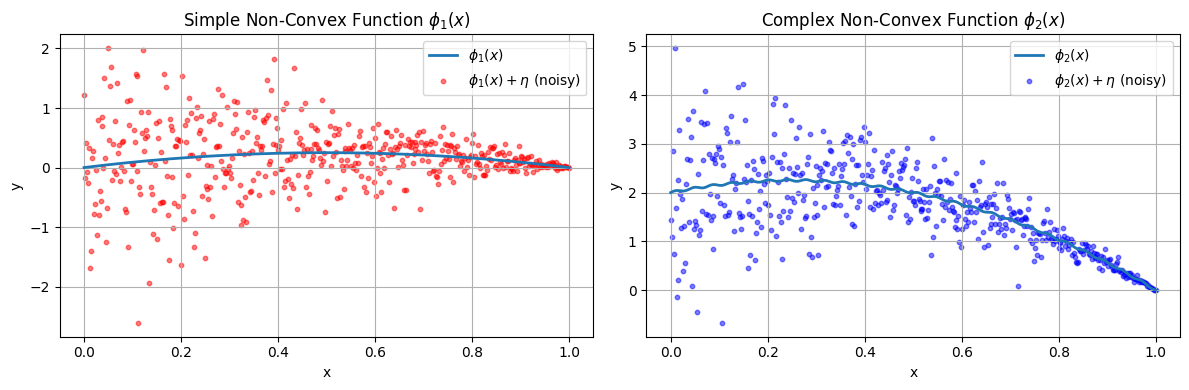

In [11]:
# plot the functions
x_vals = np.linspace(0, 1, 500)
ph_1_vals, ph_2_vals  = phi_1(x_vals), phi_2(x_vals)
ph_1_vals_noisy, ph_2_vals_noisy = ph_1_vals + gaussian_noise(x_vals), ph_2_vals + gaussian_noise(x_vals)

# Plotting the functions
plt.figure(figsize=(12,4))

# Plot phi_1
plt.subplot(1, 2, 1)
plt.plot(x_vals, ph_1_vals, label=r"$\phi_1(x)$", linewidth=2)
plt.scatter(x_vals, ph_1_vals_noisy, color="red", alpha=0.5, s=10, label=r"$\phi_1(x) + \eta$ (noisy)")
plt.title(r"Simple Non-Convex Function $\phi_1(x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

# Plot phi_2
plt.subplot(1, 2, 2)
plt.plot(x_vals, ph_2_vals, label=r"$\phi_2(x)$", linewidth=2)
plt.scatter(x_vals, ph_2_vals_noisy, color="blue", alpha=0.5, s=10, label=r"$\phi_2(x) + \eta$ (noisy)")
plt.title(r"Complex Non-Convex Function $\phi_2(x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

__Convex Functions__ : Let $X \subset \mathbb{R} $ be a convex subset and $f:X \to \mathbb{R}$ be a funtion. Then, $f$ is called convex iff:
$\forall \lambda \in [0,1]$ and $\forall x_1,x_2 \in X$:$$ f\big(\lambda x_1 + (1-\lambda)x_2\big) \leq \lambda f(x_1) + (1-\lambda) f(x_2)$$

For a _non-convex function_, the above inequality does not hold. 

__Characteristics of Non-Convex Function__:
- Multiple Extremas: As can be seen in the second plot, the surface of the function is wiggly. It oscillated (because of the `sinusoidal` component) and hence has multiple peaks. 
- Therefore, unlike convex functions, where the global optimum is the only critical point, the global optimum in non-convex functions may be hidden among many local extremas.

__Challenges__:
- Optimization algorithms (like gradient descent and its other variants) can get stuck in a local maxima/minima and failt to find the global one.
- In order to get out of the local maxima, the algorithms should have the right balance betweeen `exploration` and `exploitation`. If we keep on `exploiting` a single region, it may lead to getting stuck in a local maxima/minima.
- In addition, when the data is noisy, it can distort the observations, making it even harder to distinguish between the local and global extrema.

### 2. Thompson Sampling with Known Distribution ($\beta$-distribution)

#### The Big Picture

1. __Using Probabilistic Beliefs aka Prior Distributions__
- Thompson Sampling maintains a _posterior distribution_ for each region of the search space.
- Each subinterval $[x_{k-1},x_k)$ has its own 'belief' about its likelihood of containing the global maxima.
- We represent this belief through a probability distribution $\tilde{P}_k(t)$.

2. __Balancing Exploration and Exploitation__ This is done in two steps:
    1. `Exploration`: Sampling from the Posterior
        - Draw samples from the posterior distribution of all subintervals from $[x_{k-1},x_k)$, for all $k \in [1,T]$
        - This is _exploration_ because sampling is a random process.
    2. `Exploitation`: Choose the interval with the Highest Sample
        - The interval $k$ with the highest sample is chosen, bringing our focus on the candidate region (most promising one!)

3. __Adaptive Focus on the Promising Regions__
    - Over time, as more and more data comes in, the distribution for each region will get updates (Prior -> Posterior step)
    - The posterior distributions for the less-promising intervals will become concentrate around lower values
    - The posterior distribution for the candidate regions (intervals) will, on the other hand, concentrate around higher values

We now implement the above algorithm till now.

#### Step 1:
- Divide the interval $[0,1]$ int `m` subintervals.
- Prior Distribution $\tilde{P}_k(0) = \frac{1}{m}$ is $U(0,1)$ or $\beta(1,1)$.

(We chose proposal distribution to be $\beta$-distribution)

In [12]:
m = 10
subintervals = np.linspace(0, 1, m+1)
beliefs_alpha = np.ones(m)
beliefs_beta = np.ones(m)

#### Step 2:
- We will run `num_iterations` for Thompson Sampling i.e. our beliefs about each interval will update `num_iterations` times!
- In each loop, we sample from every interval according to that interval's belief i.e. from the posterior distribution of that interval.
- We will choose the interval with the highest sample value! 
- Once we have the `chosen_interval`, we will sample a point `chosen_x` from that interval.
- Then, we check the value of the real data at the point `chosen_x`. If it is above a certain `threshold` level, we approve the interval and increase it's confidence parameter i.e. $\alpha$ parameter of the $\beta$-distribution for the subinterval.

In [13]:
def get_reward(x, seed=None):
    rng = np.random.default_rng(seed)
    noise = rng.normal(0, (1 - x))  # Gaussian noise with variance (1-x)^2
    return phi_2(x) + noise

In [14]:
num_iterations = 100
chosen_intervals_list = []

for t in range(num_iterations):

    # sample from the interval according to their posterior distribution
    samples = [np.random.beta(beliefs_alpha[k], beliefs_beta[k]) for k in range(m)]

    # choose the interval with the highest sample value!
    chosen_interval = np.argmax(samples)
    chosen_intervals_list.append([subintervals[chosen_interval], subintervals[chosen_interval+1]])

    # sample a point from chosen_interval
    chosen_x = np.random.uniform(subintervals[chosen_interval], subintervals[chosen_interval+1])

    # observe a noisy reward at the sampled x:
    reward = get_reward(chosen_x) # noisy function at chosen_x

    # threshold
    threshold = 0
    
    # update the Beta distribution for the chosen_interval: (for now we have a very trivial update rule)
    if reward > threshold:
        beliefs_alpha[chosen_interval] += 1
    else:
        beliefs_beta[chosen_interval] += 1

    # Print the current state
    print(f"Iteration {t + 1}:")
    print(f"  Chosen Interval: [{subintervals[chosen_interval]:.2f}, {subintervals[chosen_interval + 1]:.2f}]")
    print(f"  Sampled x: {chosen_x:.4f}, Observed Reward: {reward:.4f}")
    print(f"  Updated Belief (Alpha, Beta): ({beliefs_alpha[chosen_interval]}, {beliefs_beta[chosen_interval]})\n")

Iteration 1:
  Chosen Interval: [0.00, 0.10]
  Sampled x: 0.0179, Observed Reward: 3.6318
  Updated Belief (Alpha, Beta): (2.0, 1.0)

Iteration 2:
  Chosen Interval: [0.40, 0.50]
  Sampled x: 0.4077, Observed Reward: 0.6264
  Updated Belief (Alpha, Beta): (2.0, 1.0)

Iteration 3:
  Chosen Interval: [0.90, 1.00]
  Sampled x: 0.9304, Observed Reward: 0.4429
  Updated Belief (Alpha, Beta): (2.0, 1.0)

Iteration 4:
  Chosen Interval: [0.40, 0.50]
  Sampled x: 0.4885, Observed Reward: 1.5147
  Updated Belief (Alpha, Beta): (3.0, 1.0)

Iteration 5:
  Chosen Interval: [0.90, 1.00]
  Sampled x: 0.9021, Observed Reward: 0.6116
  Updated Belief (Alpha, Beta): (3.0, 1.0)

Iteration 6:
  Chosen Interval: [0.10, 0.20]
  Sampled x: 0.1324, Observed Reward: 2.8707
  Updated Belief (Alpha, Beta): (2.0, 1.0)

Iteration 7:
  Chosen Interval: [0.10, 0.20]
  Sampled x: 0.1121, Observed Reward: 2.5708
  Updated Belief (Alpha, Beta): (3.0, 1.0)

Iteration 8:
  Chosen Interval: [0.00, 0.10]
  Sampled x: 0.06

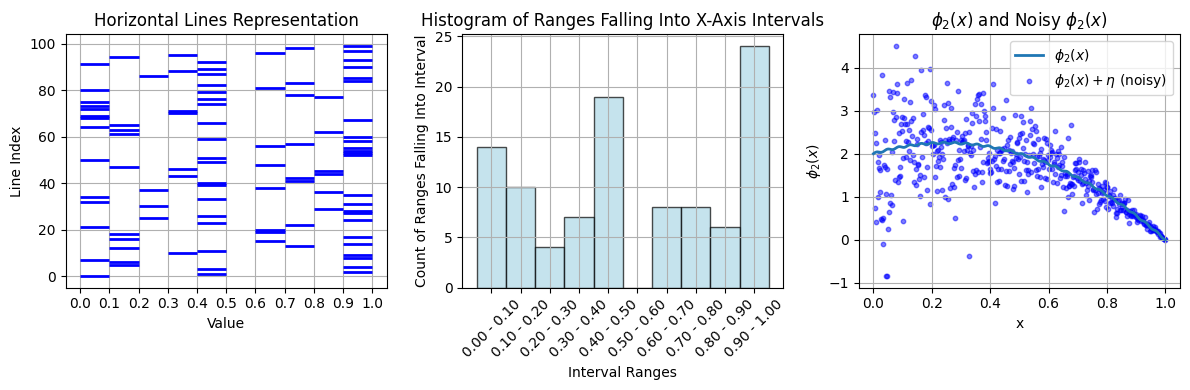

In [15]:
# Create m intervals from 0 to 1 (including boundaries)
x_ticks = np.linspace(0, 1, m+1)

# Prepare to count how many of the intervals fall into each of the m intervals
histogram_counts = np.zeros(m)  # Initialize a count for each of the m intervals

# Count how many times each range falls into each of the m intervals
for lower, upper in chosen_intervals_list:
    # For each range, check in which interval it falls
    for i in range(m):
        if (lower < x_ticks[i+1]) and (upper > x_ticks[i]):
            histogram_counts[i] += 1

# Create x values for the phi_2 plot
x_vals = np.linspace(0, 1, 500)
ph_2_vals = phi_2(x_vals)
ph_2_vals_noisy = ph_2_vals + gaussian_noise(x_vals)

# Create a figure with three subplots in a 1x3 grid
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns

# Plot for horizontal lines (on ax1)
for i, (lower, upper) in enumerate(chosen_intervals_list):
    ax1.hlines(i, lower, upper, colors='b', linewidth=2)  # Plot horizontal line at y=i

ax1.set_xticks(x_ticks)
ax1.set_xlabel("Value")
ax1.set_ylabel("Line Index")
ax1.set_title("Horizontal Lines Representation")
ax1.grid(True)

# Plot for the histogram (on ax2)
ax2.bar(range(m), histogram_counts, width=1, edgecolor='black', color='lightblue', alpha=0.7)
ax2.set_xticks(range(m))
ax2.set_xticklabels([f'{x_ticks[i]:.2f} - {x_ticks[i+1]:.2f}' for i in range(m)], rotation=45)
ax2.set_xlabel("Interval Ranges")
ax2.set_ylabel("Count of Ranges Falling Into Interval")
ax2.set_title("Histogram of Ranges Falling Into X-Axis Intervals")
ax2.grid(True)

# Plot for phi_2 and noisy phi_2 (on ax3)
ax3.plot(x_vals, ph_2_vals, label=r"$\phi_2(x)$", linewidth=2)
ax3.scatter(x_vals, ph_2_vals_noisy, color="blue", alpha=0.5, s=10, label=r"$\phi_2(x) + \eta$ (noisy)")

ax3.set_xlabel("x")
ax3.set_ylabel(r"$\phi_2(x)$")
ax3.set_title(r"$\phi_2(x)$ and Noisy $\phi_2(x)$")
ax3.grid()
ax3.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


### 3. Thompson Sampling with Unknown Distribution (Proposal-distribution)

#### Step 1: Partition the Search Space into `m` partitions
- Proposal probability is probability of choosing an subinterval out of `m` total subintervals.  For the beginning, the proposal probability is uniform for each subinterval. 

In [205]:
M = 16 # number of intervals
SEARCH_SPACE_L = 0
SEARCH_SPACE_H = 1

# define the search space
search_space = np.linspace(SEARCH_SPACE_L, SEARCH_SPACE_H, M+1)

# set up the intervals:
intervals = [[search_space[i], search_space[i+1]] for i in range(len(search_space)-1)]

#### Step 2: Set the proposal probabilities

- We will look at each interval as an arm of the Multi-armed Bandit Problem. So, we have `m` arms
- Let us setup the _prior distribution_ for each arms as $\mathcal{N}(0,1)$.
- Initially, each arm/interval as equal probability of getting picked up $\implies \forall k \in \overline{1,m}$,  $\tilde{P}_k(0)=\frac{1}{m}$ 

In [209]:
P_0 = np.ones(M)*(1/M)

#### Step 3: Thompson Sampling Iterations

- We sample from the Gaussian Prior of each interval i.e. $\forall k = \overline{1,m}$, we sample from $\mathcal{N}(\mu_k, \sigma_k^2)$. When we start, we assume we have absolutely no information about the samples, so we assume $0$ mean and unit variance.
- We pick the interval whose sampled point is the highest. Let us call it `chosen_interval`
- We then sample a point uniformly from that interval. Let that point be `chosen_point` and calculate it's value at $\phi(x) + \eta(x)$. This value is saved and the process is repeated to build the empirical distribution of each interval.


In [388]:
empirical_dist = {key: [] for key in np.arange(M)}
interval_params = {key: [0,1] for key in np.arange(M)}

In [389]:
interval_samples = [np.random.normal(interval_params[i][0], np.sqrt(interval_params[i][1])) for i in range(M)]
chosen_sample_idx = np.argmax(interval_samples)
chosen_interval = intervals[chosen_sample_idx]
chosen_point = np.random.uniform(chosen_interval[0], chosen_interval[1])
y_chosen_point = phi_2_noisy(chosen_point)
empirical_dist[chosen_sample_idx].append(y_chosen_point) 
interval_params[chosen_sample_idx][0] = np.mean(empirical_dist[chosen_sample_idx])
interval_params[chosen_sample_idx][1] = max(np.var(empirical_dist[chosen_sample_idx]), 1e-6)

In [ ]:
mu_list = [interval_params[i][0] for i in range(M)]
var_list = [interval_params[i][1] for i in range(M)]
P_t = build_proposal_probabilities(mu_list, var_list)
H_0 = get_entropy(P_0)
H_t = get_entropy(P_t)

print(f"H0: {H_0}, 0.5*H_t: {0.5*H_t}")
if(H_0 <= 0.5*H_t):
    print("Stop Learning! Repartition!!!")
else:
    print("Keep learning the current partition!")


H0: 2.772588722239781, 0.5*H_t: 0.8798215727918016


#### Step 2: Sample and Observe the Rewards

#### Step 3: Updating the Proposal Probabilities

In [88]:
M = 3
SEARCH_SPACE_L = 0
SEARCH_SPACE_H = 1
NUM_REFINEMENT = 3


search_space = np.linspace(SEARCH_SPACE_L, SEARCH_SPACE_H, M+1)
intervals = [[search_space[i], search_space[i+1]] for i in range(len(search_space)-1)]
lower_chosen, upper_chosen = intervals[0][0], intervals[-1][1]

def get_delta(m, num):
    return (1/m)**num

def get_new_chosen(lower_chosen, upper_chosen, delta):
    lower_chosen += delta
    upper_chosen -= delta
    return lower_chosen, upper_chosen

def get_entropy(proposal_probabilities):
    return -sum(p_k * np.log(p_k) for p_k in proposal_probabilities if p_k > 0)

def update_intervals(intervals, chosen_index, lower_chosen, upper_chosen):
    updated_intervals = intervals.copy()
    updated_intervals[chosen_index] = [lower_chosen, upper_chosen]  # Only update the chosen interval
    return updated_intervals

payoff_threshold = 0.05

current_refinement_number = 1
while(current_refinement_number <= NUM_REFINEMENT):

    # for each interval, we initial proposal distribution is uniform:
    proposal_probabilities = np.ones(m) / m # P_k(0) = [1/m,...,1/m]
    entropy_0 = get_entropy(proposal_probabilities)

    # Now, we will do the Thomoson Sampling:

    # Initial Belief for each interval:
    alpha = np.ones(M)
    beta = np.ones(M)

    print(f"===========Refinement Number: {current_refinement_number}===========\n")
    for iteration in range(100):

        # for each interval k, we sample with an initial belief \beta(1,1):
        samples = [np.random.beta(alpha[k], beta[k]) for k in range(M)]

        # pick the interval whose sample gave the maximum value
        chosen_interval = np.argmax(samples)
        print(f"Index of Chosen Interval: {chosen_interval}")

        # sample a new point chosen_x from the chosen_interval
        lower, upper = intervals[chosen_interval][0], intervals[chosen_interval][1]
        chosen_x = np.random.uniform(lower, upper)

        # observe the payoff at the sampled point
        payoff = phi1_with_eta(chosen_x)

        # update the distributio for the chosen interval
        if payoff >= np.max(samples):
            alpha[chosen_interval]+=1
        else:
            beta[chosen_interval]+=1

        # update the proposal probabilities
        proposal_probabilities = alpha / (alpha + beta)

        # calculate entropy H(t) for the current iteration:
        entropy_t = get_entropy(proposal_probabilities)

        # print the info:
        print(f"t: {iteration}; H(0): {entropy_0}; H(t): {entropy_t}")

        # entropy based stopping condition
        if (entropy_t <= 0.5*entropy_0):
            print("ENTROPY CONDITION USED")
            break
    print("\n")

     # --- While loop starts ---
    print(f"Partition #{current_refinement_number}")
    print(f"Delta: {delta}")
    print(f"Interval Before: {intervals}")
    print(f"Chosen Interval: [{intervals[chosen_interval][0]}, {intervals[chosen_interval][1]}]")   # print it after updating

    delta = get_delta(m, current_refinement_number)
    lower_chosen, upper_chosen = get_new_chosen(intervals[chosen_interval][0], intervals[chosen_interval][1], delta)
    intervals = update_intervals(intervals, chosen_interval, lower_chosen, upper_chosen)

    print(f"Prop Probabilities: {proposal_probabilities}")
    print(f"Interval After: {intervals}\n")

    current_refinement_number+=1
    # --- While loop ends ---



===========Refinement Number: 1===========

Index of Chosen Interval: 1
t: 0; H(0): 2.772588722239781; H(t): 1.0593512767826485
ENTROPY CONDITION USED


Partition #1
Delta: 0.000244140625
Interval Before: [[0.0, 0.3333333333333333], [0.3333333333333333, 0.6666666666666666], [0.6666666666666666, 1.0]]
Chosen Interval: [0.3333333333333333, 0.6666666666666666]
Prop Probabilities: [0.5        0.33333333 0.5       ]
Interval After: [[0.0, 0.3333333333333333], [0.3958333333333333, 0.6041666666666666], [0.6666666666666666, 1.0]]

===========Refinement Number: 2===========

Index of Chosen Interval: 2
t: 0; H(0): 2.772588722239781; H(t): 1.0593512767826485
ENTROPY CONDITION USED


Partition #2
Delta: 0.0625
Interval Before: [[0.0, 0.3333333333333333], [0.3958333333333333, 0.6041666666666666], [0.6666666666666666, 1.0]]
Chosen Interval: [0.6666666666666666, 1.0]
Prop Probabilities: [0.5        0.5        0.33333333]
Interval After: [[0.0, 0.3333333333333333], [0.3958333333333333, 0.604166666666

In [177]:
# our-non convex function
def phi(x):
    return 2 + 2*x*(1 - 2*x) + 0.02*np.sin(52*np.pi*x)

def phi_noisy(x):
    variance = (1-x)**2
    eta = np.random.normal(0, np.sqrt(variance))
    return phi(x) + eta

In [178]:
M = 16 # number of intervals
SEARCH_SPACE_L = 0
SEARCH_SPACE_H = 1

# define the search space
search_space = np.linspace(SEARCH_SPACE_L, SEARCH_SPACE_H, M+1)

# set up the intervals:
intervals = [[search_space[i], search_space[i+1]] for i in range(len(search_space)-1)]

# P(0) = [P_1(0),...,P_m(0)] -> Initial proposal probabilities for each interval
P_0 = np.ones(M)*(1/M)


#### Gaussian Prior: We believe that the function $\phi(x)$ follows a Gaussian Prior i.e. the values of the function are centered around some value `mean_prior` (which we take as 0) and with variance `variance_prior` (which we take as 1) i.e.

$$
    \phi(x) \sim \mathcal{N}(\mu_{\text{prior}}, \sigma_{\text{prior}}) = \mathcal{N}(0,1)
$$

In [179]:
prior_mean = 0
prior_variance = 1

In [180]:
# we now sample from each 'm' intervals 1 value. Each value x_k is sampled from interval k uniformly i.e. x_k \sim U(x_{k-1}, x_k)
x_k = [np.random.uniform(intervals[k][0], intervals[k][1]) for k in range(m)]

In [181]:
# noisy observation at the points
phi_noisy_list = [phi_noisy(x) for x in x_k]
phi_true_list = [phi(x) for x in x_k]

As function Noisy $\phi(x)$ was evaluated at 1 point from each interval, we can think of it as some information arrival. This helps us in updating the posterior of $\phi(x)$:
$$
    \phi_N(x_k) = \phi(x_k) + \eta(x_{k}) 
$$

__Prior Distribution of__ $\phi(x)$: $\phi(x) \sim \mathcal{N}(\mu_{0}, \sigma_0^2)$

__Likelihood of Observing Noisy__ $\phi(x)$ __at__ $x_k$: 
$$
    \mathbb{P}[\phi(x) | \phi_{\text{N}(x_k)}] = \mathcal{N} \Big(\phi_N(x) \Big| \phi(x_k), \sigma^2(x_k)  \Big)
$$

__Posterior Update of__ $\phi(x)$ (Bayes Theorem):
\begin{align}
    \mathbb{P}[ \phi(x) | \underbrace{\phi_N(x_k)}_{\text{data}}] &= \frac{\mathbb{P}[\phi(x) \cap \phi_N(x_k)]}{\mathbb{P}[\phi_N{x_k}]} \\
    &= \frac{\mathbb{P}[\phi_N(x_k)|\phi(x) ] \cdot \mathbb{P}[\phi(x)]}{\mathbb{P}[\phi_N(x_k)]} 
\end{align}


__Updated Parameters__

\begin{align}
    \mu_{\text{posterior}} &= \frac{\frac{\mu_0}{\sigma_0^2} + \frac{\phi_{N}(x_k)}{\sigma^2(x_k)}}{\frac{1}{\sigma_0^2} + \frac{1}{\sigma^2(x_k)}} \\
    \sigma_{posterior} &= \frac{1}{\frac{1}{\sigma_0^2} + \frac{1}{\sigma^2(x_k)}}
\end{align}

In [182]:
def get_likelihood(phi_x, phi_noisy, sigma_x):
    term1 = (1/np.sqrt(2*np.pi*sigma_x**2))
    term2 = np.exp(-0.5*(phi_noisy - phi_x)**2/sigma_x**2)
    return term1*term2

likelihoods = []
for i in range(m):
    sigma_sq = (1 - x_k[i])**2
    likelihood = get_likelihood(phi_true_list[i], phi_noisy_list[i], sigma_sq)
    likelihoods.append(likelihood)

print("Likelihood for Each Sampled Point:")
for i in range(m):
    print(f"Interval: {intervals[i]}, x_k: {x_k[i]}, Noisy phi(x): {phi_noisy_list[i]}, Likelihood: {likelihoods[i]}")


Likelihood for Each Sampled Point:
Interval: [0.0, 0.0625], x_k: 0.017312160472123903, Noisy phi(x): 1.9587374419682801, Likelihood: 0.41167699815678166
Interval: [0.0625, 0.125], x_k: 0.096434142488895, Noisy phi(x): 1.1740523034038823, Likelihood: 0.23750319716928275
Interval: [0.125, 0.1875], x_k: 0.17200991855036069, Noisy phi(x): 2.765864440577224, Likelihood: 0.42831745269453275
Interval: [0.1875, 0.25], x_k: 0.2045556576037903, Noisy phi(x): 2.435913579467351, Likelihood: 0.6065828281001452
Interval: [0.25, 0.3125], x_k: 0.28089945130617017, Noisy phi(x): 1.7769639688240106, Likelihood: 0.49415033344847575
Interval: [0.3125, 0.375], x_k: 0.33710585778940794, Noisy phi(x): 2.5520914704143056, Likelihood: 0.6582704851752625
Interval: [0.375, 0.4375], x_k: 0.42965795597190565, Noisy phi(x): 1.2534525022418275, Likelihood: 0.030284001558456706
Interval: [0.4375, 0.5], x_k: 0.49094340137951425, Noisy phi(x): 1.6757711593283382, Likelihood: 0.7110497173902186
Interval: [0.5, 0.5625], 

In [183]:
# updation step for the proposal probability:
def update_proposal_probabilities(P_prev, likelihoods):
    # Update the proposal probabilities (posterior) using Bayes' rule
    unnormalized_posteriors = P_prev * likelihoods
    
    # Normalize the posterior probabilities to ensure they sum to 1
    proposal_probabilities = unnormalized_posteriors / np.sum(unnormalized_posteriors)
    
    return proposal_probabilities
P_new = update_proposal_probabilities(P_0, likelihoods)
print(f"Updated Proposal Probabilities: {P_new}")

Updated Proposal Probabilities: [2.91058773e-002 1.67916569e-002 3.02823701e-002 4.28858679e-002
 3.49368049e-002 4.65402247e-002 2.14110198e-003 5.02717566e-002
 1.13258486e-001 1.36845151e-001 8.93782066e-012 2.66016493e-001
 2.30924208e-001 2.08573029e-009 1.34035569e-019 3.16416510e-282]


In [184]:
# calculate the entropy:
def calculate_entropy(P):
    # Ignore P_k where P_k == 0
    non_zero_P = P[P > 0]
    return -np.sum(non_zero_P * np.log(non_zero_P))

# initial entropy:
H_0 = calculate_entropy(P_0)
H_t = calculate_entropy(P_new)


In [185]:
# def repartition_intervals(P_new, m, search_space):
#     # Normalize the proposal distribution to sum to 1
#     P_new /= P_new.sum()

#     # Compute the cumulative distribution function (CDF)
#     cdf = np.cumsum(P_new)

#     # Create new partition points by finding quantiles from the CDF
#     new_intervals = []
#     for i in range(1, m+1):
#         # Find the index of the closest CDF value to i/m
#         index = np.searchsorted(cdf, i/m)
#         new_intervals.append([search_space[index], search_space[index+1]])

#     return new_intervals


In [171]:

if H_t > 0.5 * H_0:
    # Repartition the intervals
    new_intervals = repartition_intervals(P_new, m, search_space)
    print(f"New intervals after repartitioning: {new_intervals}")
    intervals = new_intervals  # Update the intervals for the next iteration

    # You can then proceed with updating proposal distribution P_new and repeat the process
else:
    print("Stopping Condition Met! We don't do anything more")

New intervals after repartitioning: [[0.1875, 0.25], [0.4375, 0.5], [0.4375, 0.5], [0.5, 0.5625], [0.5625, 0.625], [0.5625, 0.625], [0.5625, 0.625], [0.8125, 0.875], [0.8125, 0.875], [0.8125, 0.875], [0.8125, 0.875], [0.8125, 0.875], [0.8125, 0.875], [0.8125, 0.875], [0.8125, 0.875], [0.875, 0.9375]]


In [201]:
new_intervals, len(new_intervals)

([[0.0, 0.0625],
  (0.06640625, 0.0703125),
  (0.0703125, 0.125),
  [0.125, 0.1875],
  [0.1875, 0.25],
  [0.25, 0.3125],
  [0.3125, 0.375],
  [0.375, 0.4375],
  [0.4375, 0.5],
  [0.5, 0.5625],
  [0.5625, 0.625],
  [0.625, 0.6875],
  [0.6875, 0.75],
  [0.75, 0.8125],
  [0.8125, 0.875],
  [0.875, 0.9375],
  [0.9375, 1.0]],
 17)

In [198]:
intervals, len(intervals)

([[0.0, 0.0625],
  [0.0625, 0.125],
  [0.125, 0.1875],
  [0.1875, 0.25],
  [0.25, 0.3125],
  [0.3125, 0.375],
  [0.375, 0.4375],
  [0.4375, 0.5],
  [0.5, 0.5625],
  [0.5625, 0.625],
  [0.625, 0.6875],
  [0.6875, 0.75],
  [0.75, 0.8125],
  [0.8125, 0.875],
  [0.875, 0.9375],
  [0.9375, 1.0]],
 16)